Epoch 1/10, Loss: 0.093976
Epoch 2/10, Loss: 0.047288
Epoch 3/10, Loss: 0.034848
Epoch 4/10, Loss: 0.031649
Epoch 5/10, Loss: 0.030889
Epoch 6/10, Loss: 0.030744
Epoch 7/10, Loss: 0.030737
Epoch 8/10, Loss: 0.030753
Epoch 9/10, Loss: 0.030765
Epoch 10/10, Loss: 0.030773
Test MSE: 0.046518
Test RMSE: 0.215679


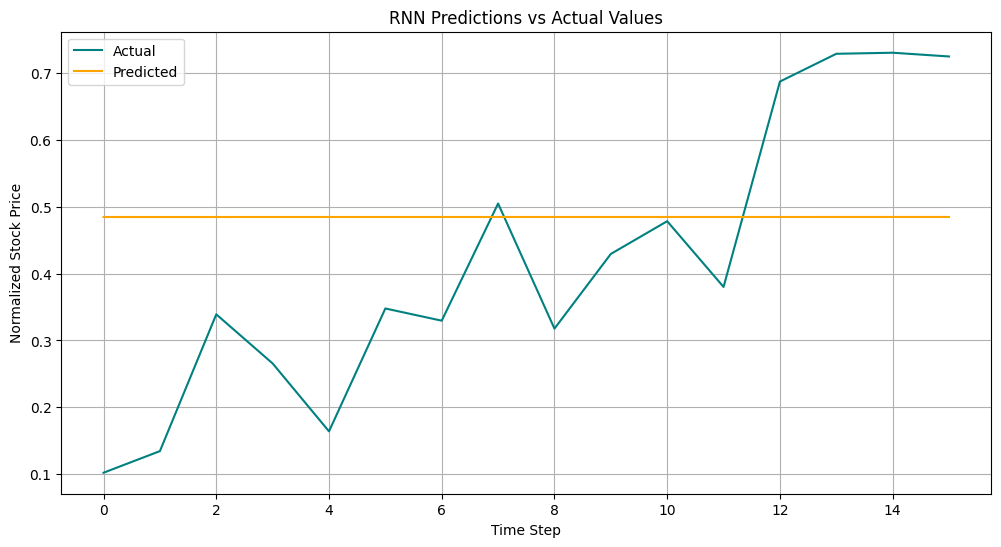

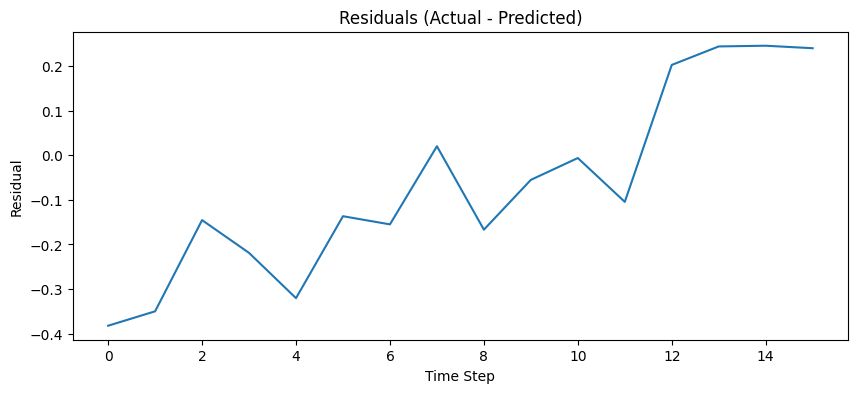

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Generate synthetic stock price data
np.random.seed(42)
stock_prices = np.sin(np.linspace(0, 20, 100)) + np.random.normal(0, 0.5, 100)

# Normalize data
stock_prices_norm = (stock_prices - np.min(stock_prices)) / (np.max(stock_prices) - np.min(stock_prices))

# Create sequences for RNN input
sequence_length = 20
X, y = [], []
for i in range(len(stock_prices_norm) - sequence_length):
    X.append(stock_prices_norm[i:i+sequence_length])
    y.append(stock_prices_norm[i+sequence_length])
X = np.array(X)
y = np.array(y)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize RNN parameters
input_size = 1
hidden_size = 10
output_size = 1
learning_rate = 0.01

# Initialize weights
Wxh = np.random.randn(hidden_size, input_size) * 0.01
Whh = np.random.randn(hidden_size, hidden_size) * 0.01
Why = np.random.randn(output_size, hidden_size) * 0.01
bh = np.zeros((hidden_size, 1))
by = np.zeros((output_size, 1))

# Activation function
def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x) ** 2

# Training parameters
epochs = 10

# Training loop
losses = []
for epoch in range(epochs):
    total_loss = 0
    for i in range(len(X_train)):
        inputs = X_train[i].reshape(sequence_length, 1)
        target = y_train[i]

        # Forward pass
        hs = np.zeros((sequence_length + 1, hidden_size, 1))
        for t in range(sequence_length):
            x_t = inputs[t].reshape(input_size, 1)
            hs[t] = tanh(np.dot(Wxh, x_t) + np.dot(Whh, hs[t-1]) + bh)
        y_pred = np.dot(Why, hs[sequence_length-1]) + by

        # Compute loss (MSE)
        loss = (y_pred - target) ** 2 / 2
        total_loss += loss

        # Backpropagation through time (BPTT)
        dWhy = np.dot((y_pred - target), hs[sequence_length-1].T)
        dby = (y_pred - target)

        dh_next = np.dot(Why.T, (y_pred - target))
        dWxh = np.zeros_like(Wxh)
        dWhh = np.zeros_like(Whh)
        dbh = np.zeros_like(bh)

        for t in reversed(range(sequence_length)):
            dh = dh_next
            # Backprop through tanh
            dtanh_val = dtanh(hs[t]) * dh
            dbh += dtanh_val
            dWxh += np.dot(dtanh_val, inputs[t].reshape(1, -1))
            dWhh += np.dot(dtanh_val, hs[t-1].T)
            dh_next = np.dot(Whh.T, dtanh_val)

        # Update weights
        Wxh -= learning_rate * dWxh
        Whh -= learning_rate * dWhh
        Why -= learning_rate * dWhy
        bh -= learning_rate * dbh
        by -= learning_rate * dby

    avg_loss = total_loss / len(X_train)
    losses.append(avg_loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss.item():.6f}")

# Prediction on test set
predictions = []
for i in range(len(X_test)):
    inputs = X_test[i].reshape(sequence_length, 1)
    hs = np.zeros((sequence_length + 1, hidden_size, 1))
    for t in range(sequence_length):
        x_t = inputs[t].reshape(input_size, 1)
        hs[t] = tanh(np.dot(Wxh, x_t) + np.dot(Whh, hs[t-1]) + bh)
    y_pred = np.dot(Why, hs[sequence_length-1]) + by
    predictions.append(y_pred.item())

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Test MSE: {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='teal')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('RNN Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
residuals = y_test - np.array(predictions)
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Time Step")
plt.ylabel("Residual")
plt.show()

